## Content:
- **[Part 1](#part1)- Importing the data set, packages used**
- **[Part 2](#part2)- Preprocessing Data**
- **[Part 3](#part3) -  Logistic Regression**
- **[Part 4](#part4) -  ANN with one Hidden Layer**
- **[Part 5](#part5) -  ANN with two Hidden Layers**
- **[Part 6](#part6) - ANN with three Hidden Layers**



[Back to top](#Content:)


<a id='part1'></a>

# Part 1 -  Importing the data set

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
%matplotlib inline

In [3]:
random.seed(0)

In [4]:
# Loading Dataset
df = pd.read_csv("healthcare/train_data.csv", na_values=['NA', '?'])

In [5]:
# Dropping na values for 
df = df.dropna()

In [6]:
# Dropping case_id
df.drop(['case_id'], axis=1, inplace=True)

[Back to top](#Content:)


<a id='part2'></a>

# Part 2 -  Preprocessing Data

### Hot Encoded Data

In [7]:
# Function to hot encode the column with name : name for dataframe df
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True) 

In [8]:
from sklearn.preprocessing import LabelEncoder 
# Columns where we use Label Encoding
le_string_columns = ['Severity of Illness', 'Age' ]
# Columns where we use One Hot Encoding
dummies_string_columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code',  'Type of Admission']
encoder = LabelEncoder()

## label_encoded data
Xe = df.drop(['Stay'], axis=1)
Xe['Severity of Illness']= Xe['Severity of Illness'].map({'Minor': 0,  'Moderate': 1,'Extreme': 2})
Xe['Age'] = encoder.fit_transform(Xe['Age'])

ye = df['Stay']
ye = encoder.fit_transform(ye)

for column in dummies_string_columns :
    encode_text_dummy(Xe, column)
    

### Scaling and splitting Data

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X = Xe.values
y = ye
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
for i in range(X_train.shape[1]) :
    X_train[:,i]= scaler.fit_transform(X_train[:,i].reshape(-1, 1))[:,0]
    X_test[:,i] = scaler.transform(X_test[:,i].reshape(-1, 1))[:,0]

### Scoring

In [10]:
K = 10 # Num of Classes 
# Classes can be ranked here from 0-10
def score(pred, target):
    error = (np.mean(np.abs(pred-target)))/K
    score = 1 - error
    return score

# Models

We start by base models, models used here are that are most adapted to the nature of the problem :
- Logistic Regression
- One Hidden Layer ANN
- Two Hidden Layer ANN


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

[Back to top](#Content:)


<a id='part3'></a>

# Part 3 -  Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegressionCV

In [15]:
model = LogisticRegressionCV(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegressionCV(max_iter=1000)

Accuracy : 0.393
Score : 0.8877


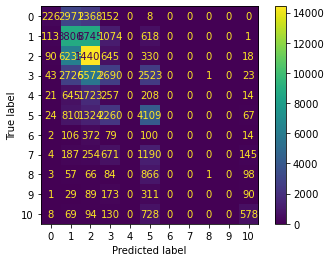

In [19]:
y_pred = model.predict(X_test)
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
print(f'Accuracy : %.3f' % accuracy_score(y_test, y_pred))
print(f'Score : %.4f' % score)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

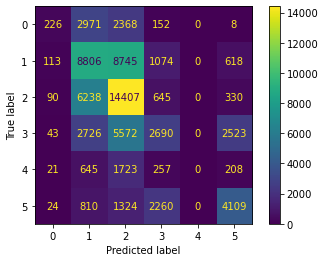

In [20]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

## Histogram to compare

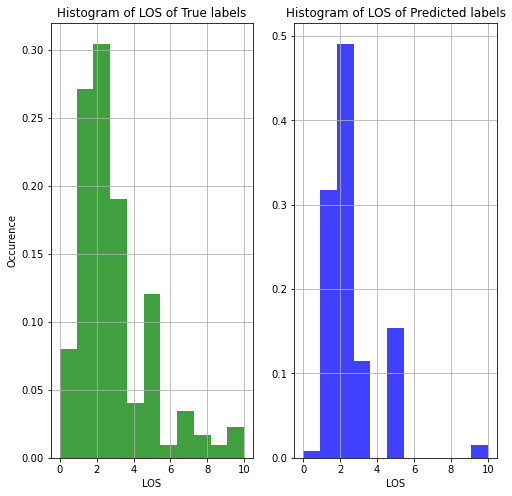

In [22]:
labels = np.unique(df['Stay'])
labels[-1] = '100+'

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(8, 8)
ax1.grid(True)
ax1.hist(y_test, bins=11, label=labels, density=True, facecolor='g', alpha=0.75)
ax1.set_title('Histogram of LOS of True labels')
ax1.set_xlabel('LOS')
ax1.set_ylabel('Occurence')

ax2.grid(True)
ax2.hist(y_pred, bins=11, label=labels, density=True, facecolor='b', alpha=0.75)
ax2.set_title('Histogram of LOS of Predicted labels')
ax2.set_xlabel('LOS')



plt.show()

Results of logistic regression are comparable to what we obtained with Random Forest, on the other hand the model never predicts categories 4,6,7,8,9 and barely predicts 0. The model optimize for accuracy.

[Back to top](#Content:)


<a id='part4'></a>

# Part 4 -  ANN with one Hidden Layer

In [28]:
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(11,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=50)



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                656       
_________________________________________________________________
dense_7 (Dense)              (None, 11)                187       
Total params: 843
Trainable params: 843
Non-trainable params: 0
_________________________________________________________________
Train on 188275 samples, validate on 47069 samples
Epoch 1/50
188275/188275 [==============================] - 7s 36us/sample - loss: 1.6818 - accuracy: 0.3674 - val_loss: 1.6081 - val_accuracy: 0.3916
Epoch 2/50
188275/188275 [==============================] - 6s 33us/sample - loss: 1.5994 - accuracy: 0.3963 - val_loss: 1.5957 - val_accuracy: 0.3950
Epoch 3/50
188275/188275 [==============================] - 6s 33us/sample - loss: 1.5908 - accuracy: 0.3995 - val_loss: 1.5907 - val_accuracy: 0.3980
Epoch 4/50
188

Accuracy score: 0.4128542110160741


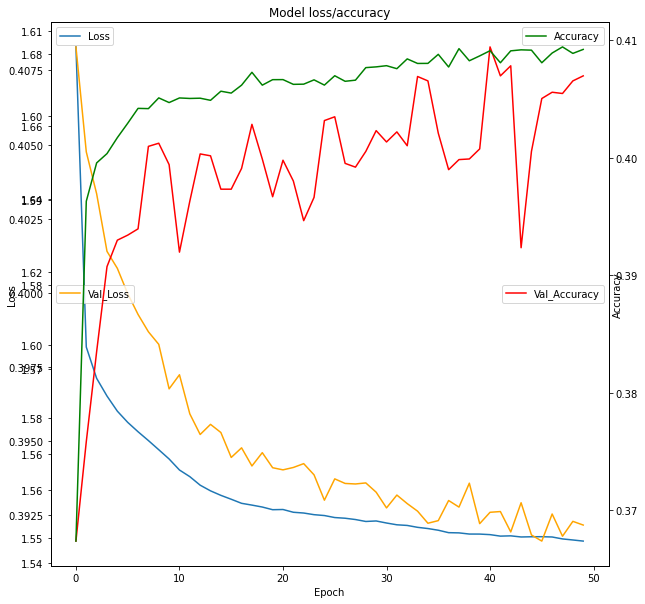

In [37]:
# Prediction
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

# Computing and printing accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy score: {}".format(accuracy))

# Plotting
plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
plt2.plot(r.history['val_loss'], color='orange')
plt2.legend(['Val_Loss'], loc='center left')


plt3=plt.twinx()
plt3.plot(r.history['val_accuracy'],color='red')
plt.ylabel('Accuracy')
plt3.legend(['Val_Accuracy'], loc='center right')

plt4=plt.twinx()
plt4.plot(r.history['accuracy'],color='green')
plt4.legend(['Accuracy'], loc='upper right')

plt.show()


### Score 

In [38]:
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
print(f'Score : %.4f' % score)


Score : 0.8915


Maybe 30 epochs were enough, it seems we are getting slightly better results thant the logistic regression, the score is higher too. Let's plot the confusion matrix and histograms to see.

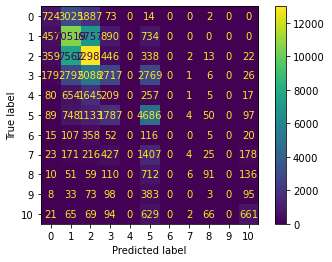

In [39]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

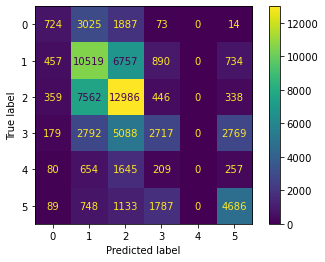

In [40]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

The confusion matrix is better than the one for logistic regression but the model still fails to predict categories 4, 6, 9

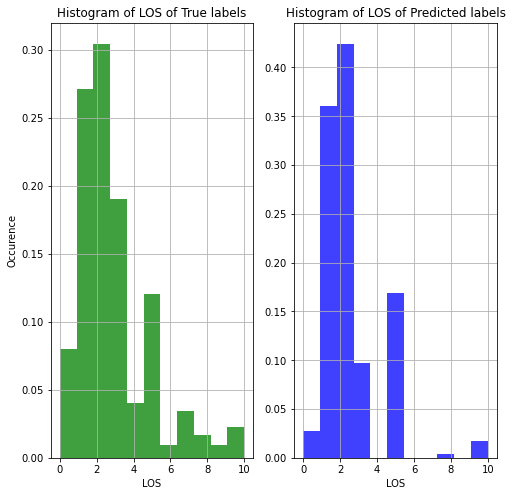

In [41]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(8, 8)
ax1.grid(True)
ax1.hist(y_test, bins=11, label=labels, density=True, facecolor='g', alpha=0.75)
ax1.set_title('Histogram of LOS of True labels')
ax1.set_xlabel('LOS')
ax1.set_ylabel('Occurence')

ax2.grid(True)
ax2.hist(y_pred, bins=11, label=labels, density=True, facecolor='b', alpha=0.75)
ax2.set_title('Histogram of LOS of Predicted labels')
ax2.set_xlabel('LOS')



plt.show()

It seems the neural network learned a little bit better about the distribution of the data, but the caveat here is that the loss function is the cross_entropy which doesn't push the network to learn that the categories rank matters.

## Trying Model with different parameters :
- Optimizer = SGD
- More Hidden Nodes
- Dropout

In [47]:
model = Sequential()

model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(11,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
model.summary()
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=30)



Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 64)                2624      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 11)                715       
Total params: 3,339
Trainable params: 3,339
Non-trainable params: 0
_________________________________________________________________
Train on 188275 samples, validate on 47069 samples
Epoch 1/30
188275/188275 [==============================] - 14s 75us/sample - loss: 1.7357 - accuracy: 0.3512 - val_loss: 1.6205 - val_accuracy: 0.3882
Epoch 2/30
188275/188275 [==============================] - 13s 71us/sample - loss: 1.6306 - accuracy: 0.3850 - val_loss: 1.6036 - val_accuracy: 0.3914
Epoch 3/30
188275/188275 [=

### Accuracy and Loss plots

Accuracy score: 0.412000152965621


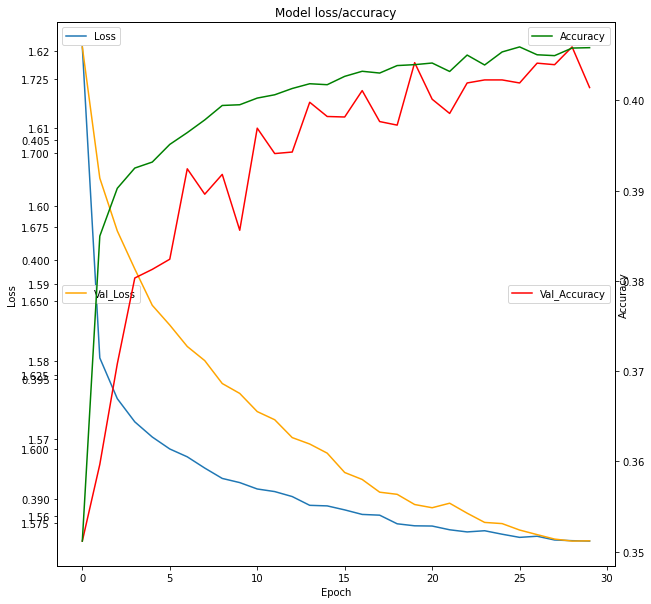

In [48]:
# Prediction
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

# Computing and printing accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy score: {}".format(accuracy))

# Plotting
plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
plt2.plot(r.history['val_loss'], color='orange')
plt2.legend(['Val_Loss'], loc='center left')


plt3=plt.twinx()
plt3.plot(r.history['val_accuracy'],color='red')
plt.ylabel('Accuracy')
plt3.legend(['Val_Accuracy'], loc='center right')

plt4=plt.twinx()
plt4.plot(r.history['accuracy'],color='green')
plt4.legend(['Accuracy'], loc='upper right')

plt.show()


### Score

In [49]:
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
print(f'Score : %.4f' % score)


Score : 0.8916


### Confusion matrix

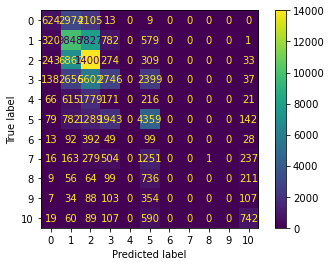

In [50]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

We get similar results to logistic regression, maybe increasing number of hidden nodes push the neural network to some sort of overfitting, let's try with fewer hidden nodes before moving to 2 hidden layer network

## Trying Model with fewer hidden nodes :


In [51]:
model = Sequential()
model.add(Dense(8, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(11,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=30)



Train on 188275 samples, validate on 47069 samples
Epoch 1/30
188275/188275 [==============================] - 8s 42us/sample - loss: 1.7348 - accuracy: 0.3450 - val_loss: 1.6191 - val_accuracy: 0.3822
Epoch 2/30
188275/188275 [==============================] - 8s 43us/sample - loss: 1.6492 - accuracy: 0.3726 - val_loss: 1.6113 - val_accuracy: 0.3865
Epoch 3/30
188275/188275 [==============================] - 7s 39us/sample - loss: 1.6411 - accuracy: 0.3745 - val_loss: 1.6085 - val_accuracy: 0.3895
Epoch 4/30
188275/188275 [==============================] - 7s 39us/sample - loss: 1.6367 - accuracy: 0.3774 - val_loss: 1.6050 - val_accuracy: 0.3858
Epoch 5/30
188275/188275 [==============================] - 8s 40us/sample - loss: 1.6349 - accuracy: 0.3766 - val_loss: 1.6069 - val_accuracy: 0.3864
Epoch 6/30
188275/188275 [==============================] - 7s 39us/sample - loss: 1.6339 - accuracy: 0.3763 - val_loss: 1.6045 - val_accuracy: 0.3891
Epoch 7/30
188275/188275 [=================

## Accuracy and Loss plots

Accuracy score: 0.3959260156279876


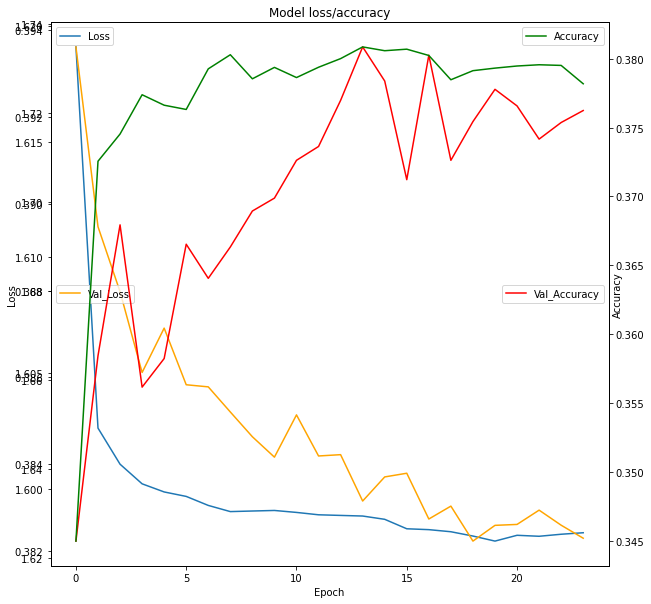

In [52]:
# Prediction
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

# Computing and printing accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy score: {}".format(accuracy))

# Plotting
plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
plt2.plot(r.history['val_loss'], color='orange')
plt2.legend(['Val_Loss'], loc='center left')


plt3=plt.twinx()
plt3.plot(r.history['val_accuracy'],color='red')
plt.ylabel('Accuracy')
plt3.legend(['Val_Accuracy'], loc='center right')

plt4=plt.twinx()
plt4.plot(r.history['accuracy'],color='green')
plt4.legend(['Accuracy'], loc='upper right')

plt.show()


### Score

In [53]:
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
print(f'Score : %.4f' % score)


Score : 0.8893


### Confusion Matrix

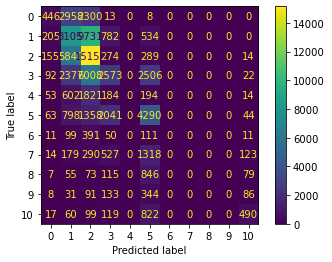

In [54]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

This model suffers from the same problem, hence we are going to move to the next step.

[Back to top](#Content:)


<a id='part5'></a>

# Part 5 -  ANN with two Hidden Layers

In [55]:
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(11,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=50)



Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 16)                656       
_________________________________________________________________
dense_19 (Dense)             (None, 24)                408       
_________________________________________________________________
dense_20 (Dense)             (None, 11)                275       
Total params: 1,339
Trainable params: 1,339
Non-trainable params: 0
_________________________________________________________________
Train on 188275 samples, validate on 47069 samples
Epoch 1/50
188275/188275 [==============================] - 8s 43us/sample - loss: 1.6370 - accuracy: 0.3790 - val_loss: 1.5801 - val_accuracy: 0.3952
Epoch 2/50
188275/188275 [==============================] - 7s 40us/sample - loss: 1.5662 - accuracy: 0.4028 - val_loss: 1.5598 - val_accuracy: 0.4032
Epoch 3/50
188275/188275 [===

## Accuracy and loss plots

Accuracy score: 0.41258652117936495


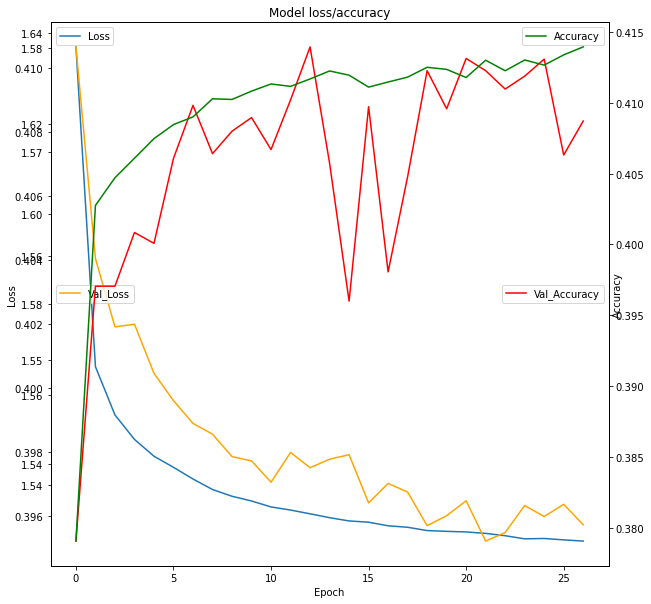

In [56]:
# Prediction
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

# Computing and printing accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy score: {}".format(accuracy))

# Plotting
plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
plt2.plot(r.history['val_loss'], color='orange')
plt2.legend(['Val_Loss'], loc='center left')


plt3=plt.twinx()
plt3.plot(r.history['val_accuracy'],color='red')
plt.ylabel('Accuracy')
plt3.legend(['Val_Accuracy'], loc='center right')

plt4=plt.twinx()
plt4.plot(r.history['accuracy'],color='green')
plt4.legend(['Accuracy'], loc='upper right')

plt.show()


### Score 

In [57]:
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
print(f'Score : %.4f' % score)


Score : 0.8917


### Confusion Matrix

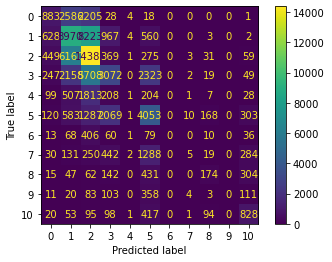

In [58]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

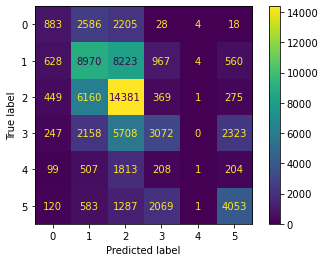

In [59]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

This looks like the best result we got so far, yet the neural network still fails to predict category 9 and 6 and only low number of prediction for categories 4 and 7, Lets look at the histograms.

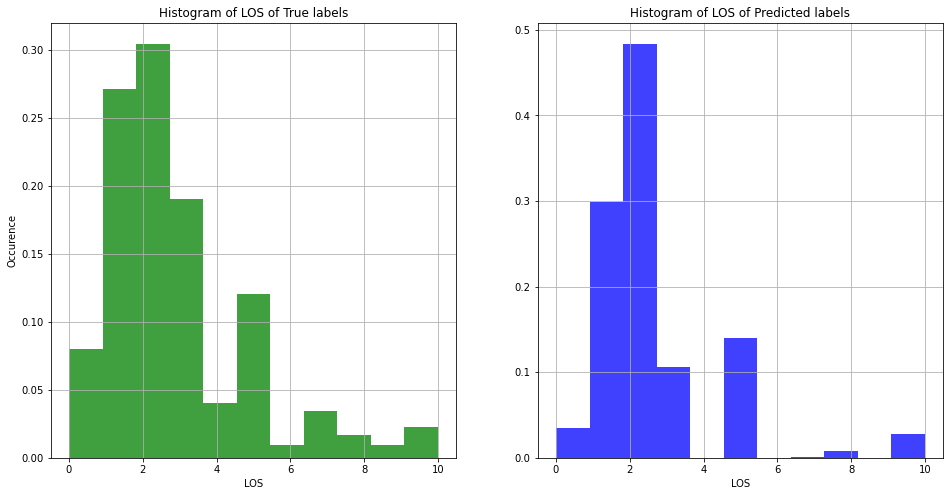

In [61]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)
ax1.grid(True)
ax1.hist(y_test, bins=11, label=labels, density=True, facecolor='g', alpha=0.75)
ax1.set_title('Histogram of LOS of True labels')
ax1.set_xlabel('LOS')
ax1.set_ylabel('Occurence')

ax2.grid(True)
ax2.hist(y_pred, bins=11, label=labels, density=True, facecolor='b', alpha=0.75)
ax2.set_title('Histogram of LOS of Predicted labels')
ax2.set_xlabel('LOS')



plt.show()

Indeed we still suffer from the same problem but with less intensity. Let's try different number of nodes

### Model with different number of nodes

In [62]:
model = Sequential()
model.add(Dense(24, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(11,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=50)



Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 24)                984       
_________________________________________________________________
dense_22 (Dense)             (None, 32)                800       
_________________________________________________________________
dense_23 (Dense)             (None, 11)                363       
Total params: 2,147
Trainable params: 2,147
Non-trainable params: 0
_________________________________________________________________
Train on 188275 samples, validate on 47069 samples
Epoch 1/50
188275/188275 [==============================] - 8s 44us/sample - loss: 1.6273 - accuracy: 0.3819 - val_loss: 1.5758 - val_accuracy: 0.3991
Epoch 2/50
188275/188275 [==============================] - 7s 39us/sample - loss: 1.5630 - accuracy: 0.4038 - val_loss: 1.5568 - val_accuracy: 0.4049
Epoch 3/50
188275/188275 [==

Accuracy score: 0.41497023543958494


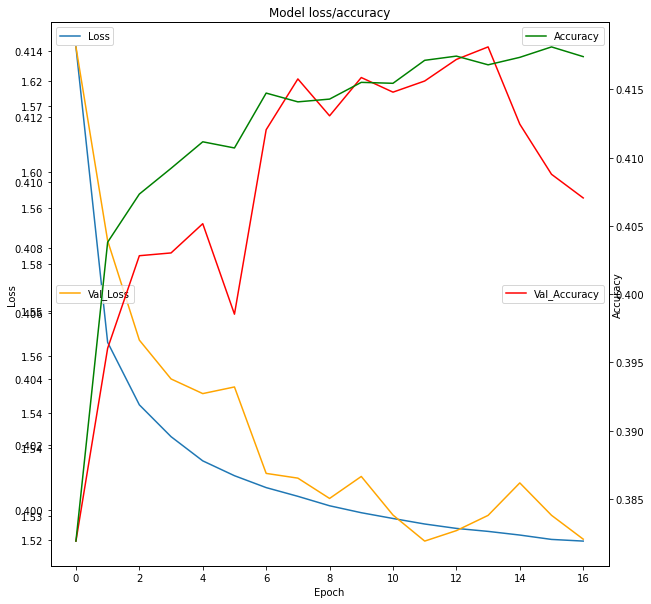

In [63]:
# Prediction
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

# Computing and printing accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy score: {}".format(accuracy))

# Plotting
plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
plt2.plot(r.history['val_loss'], color='orange')
plt2.legend(['Val_Loss'], loc='center left')


plt3=plt.twinx()
plt3.plot(r.history['val_accuracy'],color='red')
plt.ylabel('Accuracy')
plt3.legend(['Val_Accuracy'], loc='center right')

plt4=plt.twinx()
plt4.plot(r.history['accuracy'],color='green')
plt4.legend(['Accuracy'], loc='upper right')

plt.show()


### Score

In [64]:
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
print(f'Score : %.4f' % score)


Score : 0.8914


### Confusion matrix

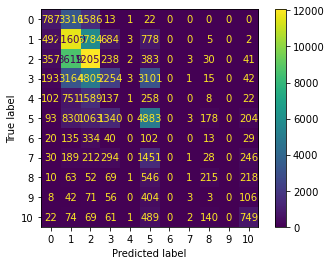

In [65]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

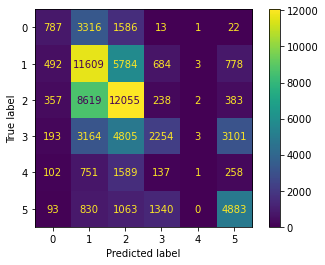

In [66]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

Same conclusion as before. One other 2 hidden layer network with more hidden nodes before trying something else.

### Trying more nodes

In [67]:
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(11,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=50)



Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                1312      
_________________________________________________________________
dense_25 (Dense)             (None, 84)                2772      
_________________________________________________________________
dense_26 (Dense)             (None, 11)                935       
Total params: 5,019
Trainable params: 5,019
Non-trainable params: 0
_________________________________________________________________
Train on 188275 samples, validate on 47069 samples
Epoch 1/50
188275/188275 [==============================] - 15s 78us/sample - loss: 1.6119 - accuracy: 0.3867 - val_loss: 1.5749 - val_accuracy: 0.3905
Epoch 2/50
188275/188275 [==============================] - 14s 73us/sample - loss: 1.5503 - accuracy: 0.4070 - val_loss: 1.5461 - val_accuracy: 0.4053
Epoch 3/50
188275/188275 [

### Loss and accuracy plots 

Accuracy score: 0.41736669683488636


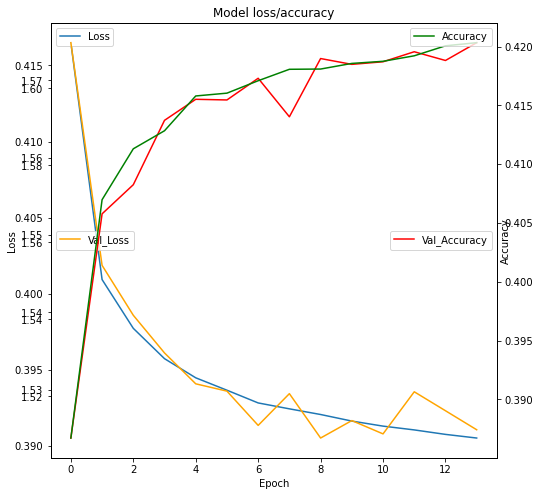

In [68]:
# Prediction
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

# Computing and printing accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy score: {}".format(accuracy))

# Plotting
plt.figure(figsize=(8,8))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
plt2.plot(r.history['val_loss'], color='orange')
plt2.legend(['Val_Loss'], loc='center left')


plt3=plt.twinx()
plt3.plot(r.history['val_accuracy'],color='red')
plt.ylabel('Accuracy')
plt3.legend(['Val_Accuracy'], loc='center right')

plt4=plt.twinx()
plt4.plot(r.history['accuracy'],color='green')
plt4.legend(['Accuracy'], loc='upper right')

plt.show()


### Score

In [69]:
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
print(f'Score : %.4f' % score)


Score : 0.8916


### Confusion Matrix

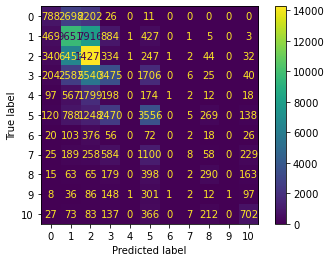

In [70]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

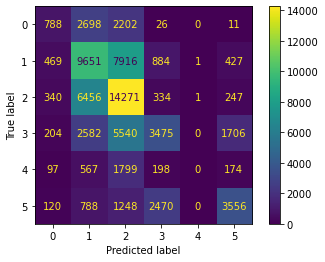

In [71]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

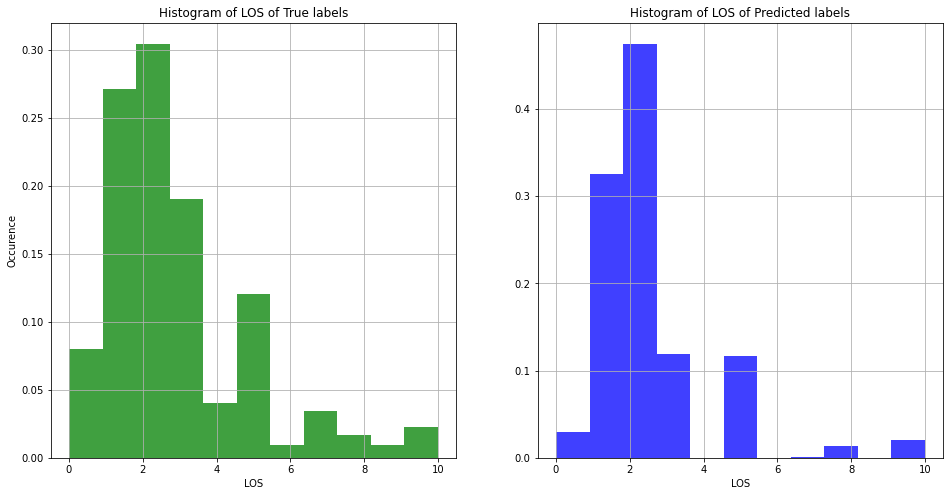

In [72]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)
ax1.grid(True)
ax1.hist(y_test, bins=11, label=labels, density=True, facecolor='g', alpha=0.75)
ax1.set_title('Histogram of LOS of True labels')
ax1.set_xlabel('LOS')
ax1.set_ylabel('Occurence')

ax2.grid(True)
ax2.hist(y_pred, bins=11, label=labels, density=True, facecolor='b', alpha=0.75)
ax2.set_title('Histogram of LOS of Predicted labels')
ax2.set_xlabel('LOS')



plt.show()

The NN appear to have learned a little bit better the distribution of the data, that means using more layers might help we will try that now.

[Back to top](#Content:)


<a id='part6'></a>

# Part 6 -  ANN with three Hidden Layers

In [74]:
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(11,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=50)



Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 16)                656       
_________________________________________________________________
dense_32 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_33 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_34 (Dense)             (None, 11)                715       
Total params: 4,027
Trainable params: 4,027
Non-trainable params: 0
_________________________________________________________________
Train on 188275 samples, validate on 47069 samples
Epoch 1/50
188275/188275 [==============================] - 9s 46us/sample - loss: 1.6175 - accuracy: 0.3816 - val_loss: 1.5681 - val_accuracy: 0.3970
Epoch 2/50
188275/188275 [=====================

## Loss and accuracy plots

Accuracy score: 0.4139759589032365


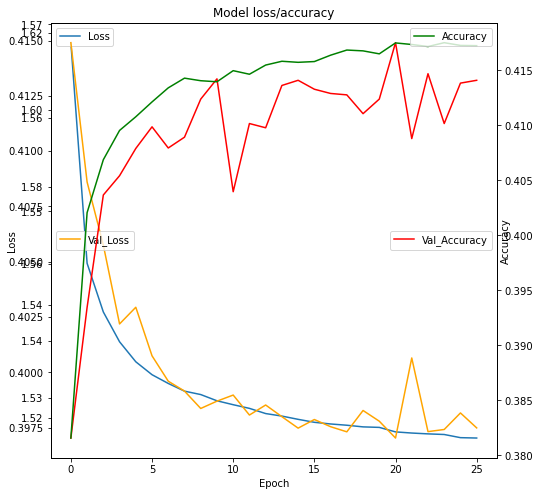

In [75]:
# Prediction
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

# Computing and printing accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy score: {}".format(accuracy))

# Plotting
plt.figure(figsize=(8,8))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
plt2.plot(r.history['val_loss'], color='orange')
plt2.legend(['Val_Loss'], loc='center left')


plt3=plt.twinx()
plt3.plot(r.history['val_accuracy'],color='red')
plt.ylabel('Accuracy')
plt3.legend(['Val_Accuracy'], loc='center right')

plt4=plt.twinx()
plt4.plot(r.history['accuracy'],color='green')
plt4.legend(['Accuracy'], loc='upper right')

plt.show()


### Score

In [76]:
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
print(f'Score : %.4f' % score)


Score : 0.8909


### Confusion Matrix

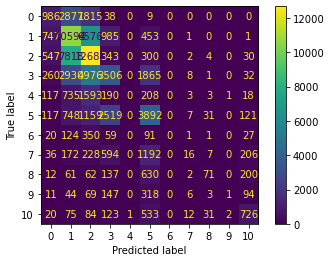

In [77]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

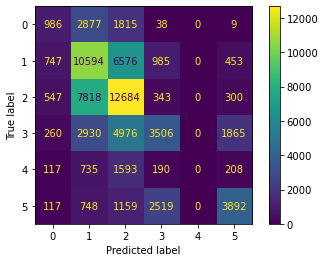

In [78]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

Results are slightly better but the neural network still fails to predict cat 4 and 6. We will move on to explore new ideas.